# A Network of Lookup Tables

In [2]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score

%matplotlib inline

## Example 2

A network of k = 2 layers.
The first layer has 2 luts.
The second layer has 1 lut.

In [3]:
train_set = [([0,0,0],0),([0,0,0],1),([0,0,0],1),([0,0,1],1),([1,0,0],0),([1,1,0],0),([1,1,0],1)]
X_train = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,1],[1,0,0],[1,1,0],[1,1,0]])
y_train = np.array([0,1,1,1,0,0,1])

In [19]:
class LUT:
    def __init__(self, inputs, indexes_0, indexes_1, k , index = []):
        # build lut
        self.k = k
        if (index == []):
            self.index = np.sort(np.random.choice(len(inputs[0]),k,replace = False))
        else:
            self.index = index
        self.subset = inputs[:,self.index]
        self.inv = np.arange(k-1,-1,-1)
        self.output = np.zeros((2**k), int)
        self.count_0 = np.zeros((2**k), int)
        self.count_1 = np.zeros((2**k), int)
        self.count(indexes_0,indexes_1)
        
    def count(self, indexes_0, indexes_1):
        zeros = Counter(np.sort(self.get_index_vec_to_dec(self.subset[indexes_0])))
        ones =  Counter(np.sort(self.get_index_vec_to_dec(self.subset[indexes_1])))
        for key in zeros.keys():
            self.count_0[key] = zeros[key]
        for key in ones.keys():
            self.count_1[key] = ones[key]
        # compute lut
        self.output[self.count_0 > self.count_1] = 0
        self.output[self.count_0 < self.count_1] = 1
        # picked uniformly at random
        self.output[self.count_0 == self.count_1] = np.random.choice([0,1], len(self.output[self.count_0 == self.count_1]))
        
    def get_index_vec_to_dec(self, X , axis = 1):
        dec_index = np.sum(X * np.power(2*np.ones(k,int),self.inv),axis= axis)
        return dec_index
    
    def get_index_dec_to_vec(self, dec):
        return "{0:b}".format(dec).zfill(self.k)
    
    def look(self, X):
        # X is a numpy array
        X = np.array(X)
        return self.output[self.get_index_vec_to_dec(X[self.index], 0)]
    
    def look_array(self, dataset):
        subdataset = dataset[:,self.index]
        return self.output[self.get_index_vec_to_dec(subdataset)]
        
    def score(self, labels, dataset):
        self.predicted = self.look_array(dataset)
        return accuracy_score(labels,predicted)
    
    def show(self):
        print("Look up table")
        print("Index = {}".format(self.index))
        print("  p    |  y0 |  y1 |  f   |")
        for i in range(len(self.output)):
            if (self.count_0[i] == self.count_1[i]):
                f = "{}*".format(self.output[i])
            else:
                f = "{} ".format(self.output[i])
            print("  {}   |  {}  |  {}  |  {}  |".format(self.get_index_dec_to_vec(i), self.count_0[i], self.count_1[i], f))

In [5]:
#index = np.sort(np.random.choice(len(train_set[0][0]),k,replace = False))
k = 2
index = [0,1]
lut = LUT(X_train,np.where(y_train == 0), np.where(y_train == 1), 2, index)
lut.show()
print("predict [0,0,0] : {}".format(lut.look(np.array([0,0,0]))))
print("accuracy : {}".format(lut.score(y_train, X_train)))

Look up table
Index = [0, 1]
  p    |  y0 |  y1 |  f   |
  00   |  1  |  3  |  1   |
  01   |  0  |  0  |  0*  |
  10   |  1  |  0  |  0   |
  11   |  1  |  1  |  0*  |
predict [0,0,0] : 1
accuracy : 0.7142857142857143


In [6]:
n_luts = [2, 1] # number of luts per layer
k = 2 # sampling input

# make a Network of look up table
layers = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)
outputs = np.zeros((len(X_train),n_luts[0]),int)

# first layer
print(" ==== first layer === \n")
layer = []
for i in range(n_luts[0]):
    # build lut
    lut = LUT(X_train, indexes_0, indexes_1, k)
    lut.show()
    outputs[:,i] = lut.look_array(X_train)
    layer.append(lut)
layers.append(layer)

# second layer
print("\n ==== second layer === \n")
layer = []
inputs = outputs
outputs = np.zeros((len(X_train),n_luts[1]),int)
for i in range(n_luts[1]):
    lut = LUT(inputs, indexes_0, indexes_1, k)
    lut.show()
    outputs[:,i] = lut.look_array(inputs)
    layer.append(lut)
layers.append(layer) 

 ==== first layer === 

Look up table
Index = [0 2]
  p    |  y0 |  y1 |  f   |
  00   |  1  |  2  |  1   |
  01   |  0  |  1  |  1   |
  10   |  2  |  1  |  0   |
  11   |  0  |  0  |  0*  |
Look up table
Index = [1 2]
  p    |  y0 |  y1 |  f   |
  00   |  2  |  2  |  1*  |
  01   |  0  |  1  |  1   |
  10   |  1  |  1  |  1*  |
  11   |  0  |  0  |  1*  |

 ==== second layer === 

Look up table
Index = [0 1]
  p    |  y0 |  y1 |  f   |
  00   |  0  |  0  |  1*  |
  01   |  2  |  1  |  0   |
  10   |  0  |  0  |  0*  |
  11   |  1  |  3  |  1   |


## Experiment 1

A Network with 5 hidden layers of 1024 luts and 1 lut in the output layer. k = 9.

### Load MNIST

In [25]:
"""
def loadMNIST(prefix, folder):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images.idx3-ubyte', dtype = 'ubyte' )
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels.idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", "./data/mnist" )
testImages, testLabels = loadMNIST( "t10k", "./data/mnist" )

from ipywidgets import FloatProgress
from IPython.display import display

X_train = np.zeros((60000,784), int)
y_train = np.zeros((60000),int)
threshold=0.3 * 255
f = FloatProgress(min=0, max=trainingImages.shape[0])
display(f)
for i in range(trainingImages.shape[0]): 
    f.value+=1
    X_train[i,:]= 1.0*(trainingImages[i].reshape(784)>threshold)
y_train[trainingLabels>4] = 1
print(X_train.shape)

X_test = np.zeros((10000,784), int)
y_test = np.zeros((10000),int)
threshold=0.3 * 255
f = FloatProgress(min=0, max=testImages.shape[0])
display(f)
for i in range(testImages.shape[0]): 
    f.value+=1
    X_test[i,:]= 1.0*(testImages[i].reshape(784)>threshold)
y_test[testLabels>4] = 1
print(X_test.shape)

with open('./data/mnist/mnist_X_train.p', 'wb') as f:
    pickle.dump(X_train, f)
with open('./data/mnist/mnist_y_train.p', 'wb') as f:
    pickle.dump(y_train, f)
with open('./data/mnist/mnist_X_test.p', 'wb') as f:
    pickle.dump(X_test, f)
with open('./data/mnist/mnist_y_test.p', 'wb') as f:
    pickle.dump(y_test, f)
"""

FloatProgress(value=0.0, max=60000.0)

(60000, 784)


FloatProgress(value=0.0, max=10000.0)

In [26]:
with open('./data/mnist/mnist_X_train.p', 'rb') as f:
    X_train = pickle.load(f)
with open('./data/mnist/mnist_y_train.p', 'rb') as f:
    y_train = pickle.load(f)
with open('./data/mnist/mnist_X_test.p', 'rb') as f:
    X_test = pickle.load(f)
with open('./data/mnist/mnist_y_test.p', 'rb') as f:
    y_test = pickle.load(f)

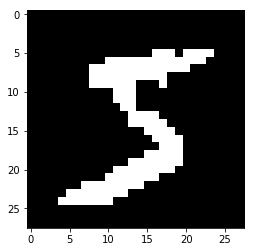

In [9]:
plt.imshow(X_train[0].reshape(28,28) , matplotlib.pyplot.cm.gray)

### Build Network

In [10]:
from tqdm import tqdm

n_luts = [784, 1024,1024,1024,1024,1024,1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    lut = LUT(inputs, indexes_0, indexes_1, k)
    outputs[:,i] = lut.look_array(inputs)
    layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,7):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)

layer 0 nb luts : 784


100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [01:04<00:00, 12.20it/s]


layer 1 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:22<00:00, 12.37it/s]


layer 2 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:22<00:00, 12.45it/s]


layer 3 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:22<00:00, 12.98it/s]


layer 4 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:23<00:00, 11.86it/s]


layer 5 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:25<00:00, 11.94it/s]


layer 6 nb luts : 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.84it/s]


In [17]:
print("Experiment 1 : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

Experiment 1 : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.000000
mean,0.611867,0.755240,0.843522,0.879176,0.893693,0.901817,0.907967
std,0.042915,0.018114,0.006528,0.002940,0.001192,0.000582,NaN
min,0.511400,0.688167,0.822600,0.870550,0.890050,0.900050,0.907967
25%,0.581438,0.743533,0.839142,0.877117,0.892917,0.901462,0.907967
50%,0.607625,0.755725,0.843658,0.879375,0.893675,0.901783,0.907967
75%,0.642892,0.767517,0.848058,0.881154,0.894450,0.902167,0.907967
max,0.739517,0.802800,0.862533,0.889133,0.897600,0.903900,0.907967


In [31]:
# Compute test accuracy

# input layer
k = 8

test_accuracy = []

inputs = X_test
outputs = np.zeros((len(X_test),len(layers[0])),int)
accuracy = []
for i in tqdm(range(len(layers[0]))):
    score = layers[0][i].score(y_test, inputs)
    outputs[:,i] = layers[0][i].look_array(inputs)
    accuracy.append(score)
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        #outputs[:,i] = lut.predicted
        accuracy.append(score)
    test_accuracy.append(accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.35it/s]


In [32]:
print("Experiment 1 : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Experiment 1 : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.0000
mean,0.614273,0.757236,0.841769,0.872953,0.881972,0.884727,0.8851
std,0.046526,0.019889,0.007540,0.003648,0.002017,0.001489,NaN
min,0.508900,0.688600,0.814900,0.860200,0.875800,0.880400,0.8851
25%,0.579750,0.744200,0.836800,0.870700,0.880600,0.883700,0.8851
50%,0.609400,0.758200,0.842000,0.873000,0.882000,0.884700,0.8851
75%,0.647300,0.771425,0.846700,0.875400,0.883325,0.885800,0.8851
max,0.749000,0.806800,0.866200,0.888200,0.889400,0.890500,0.8851
